In [1]:
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import sys
sys.path.append('../')
from utils.tools import *
from utils.model import *
device = torch.device('cpu')

In [2]:
epochs = 3000
Dimension = 3
n_f = Dimension
msg_dim = 1
dim = Dimension
tau = 1
lam = 0.1
dt = 0.001
# epc = 2800
# Dyn = edegsInfer(Dimension, dt, edge_num,tau,lam,aggr='add').to(device)


In [3]:
import glob

def load_all_weight(resu_prefix, epc, Nodes):
    weights_file = glob.glob(resu_prefix + f'weights_over_time_lam*_e{epc-1}.pkl')
    for name in weights_file:
        with open(name, 'rb') as f:
            weights = pickle.load(f)
    eva_file = glob.glob(resu_prefix + f'Eva_lam*_e{epc-1}.csv')
    for name in eva_file:
        Eva = pd.read_csv(name)
    # return Loss[epc-epochs-1], val_loss[epc-epochs-1], weights[-1], Eva.iloc[-1,1], Eva.iloc[-1,2]
    return weights[-1], Eva.iloc[-1,1], Eva.iloc[-1,2]


In [4]:
def load_and_append_weight(Nodes, resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time):
    weight, auc, auprc = load_all_weight(resu, epc, Nodes)
    # loss_over_time.append(loss)
    # val_loss_over_time.append(val_loss)
    weights_over_time.append(weight)
    auc_over_time.append(auc)
    auprc_over_time.append(auprc)

In [5]:
import torch
from torch.functional import F
def weights2Bi(weights_over_time, threshold):
    weights_ind = torch.tensor(weights_over_time)
    Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()

    bi_bestWei = np.where(bestWei<threshold, 0, 1) # 0 or 1 for each edge
    bi_Stru = np.zeros((nodes_num, nodes_num))
    mask = np.ones((nodes_num, nodes_num), dtype=bool)
    np.fill_diagonal(mask, 0)
    bi_Stru[mask] = bi_bestWei.squeeze()
    return bi_Stru.T

def cal_fro_error(objectAij,infer_struc):
    error = np.linalg.norm(objectAij - infer_struc, 'fro')/np.linalg.norm(objectAij, 'fro')
    return error

def cal_new_error(objectAij,infer_struc):
    error = np.sum(np.abs(objectAij-infer_struc))/(objectAij.shape[0]*(objectAij.shape[0]-1))
    return error

def struc_error(objectAij,infer_struc):
    error = np.sum(np.abs(objectAij-infer_struc))/np.sum(np.abs(objectAij))
    return error

In [6]:
m1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2,2.5,3]
exp_ind = [1,2,3,4,5]

In [ ]:
epc = 3000
Nodes = 10
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []
M = [int(m1[i]*Nodes) for i in range(len(m1))] # timepoints by subsampling
exp_ind = [1,2,3,4,5]

for i in range(len(exp_ind)):
    for t in M:
        resu = f'kndyn/knDyn_Nodes{Nodes}_Times40_M{t}_exp{exp_ind}/'
        load_and_append_weight(Nodes, resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

print(len(weights_over_time))

60


In [8]:
from sklearn.metrics import average_precision_score

edges = int(2*Nodes)
Time = 50
with open(f'data/Series_N{Nodes}_M{edges}_T{Time}_ind1.pickle', 'rb') as f:
    objectAij, data = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc10 = []
Bi_auprc10 = []
error10 = []

for ii in range(len(M)*len(exp_ind)):
    
    threshold = 0.5
    bi_Stru = weights2Bi(weights_over_time[ii],threshold)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc10.append(bi_Stru)
    Bi_auprc10.append(bi_aupr)
    # error10.append(cal_new_error(objectAij,bi_Stru))
    error10.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 3000
Nodes = 15
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []
M = [int(m1[i]*Nodes) for i in range(len(m1))] # timepoints by subsampling
exp_ind = [1,2,3,4,5]

for i in range(len(exp_ind)):
    for m in M:
        resu = f'kndyn/knDyn_Nodes{Nodes}_Times40_m{m}_exp{exp_ind}/'
        load_and_append_weight(Nodes, resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

print(len(weights_over_time))

60


In [10]:
from sklearn.metrics import average_precision_score

edges = int(2*Nodes)
Time = 50
with open(f'data/Series_N{Nodes}_M{edges}_T{Time}_ind1.pickle', 'rb') as f:
    objectAij, data = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc15 = []
Bi_auprc15 = []
error15 = []

for ii in range(len(M)*len(exp_ind)):
    
    threshold = 0.5
    bi_Stru = weights2Bi(weights_over_time[ii],threshold)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc15.append(bi_Stru)
    Bi_auprc15.append(bi_aupr)
    # error15.append(cal_new_error(objectAij,bi_Stru))
    error15.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 3000
Nodes = 20
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []
M = [int(m1[i]*Nodes) for i in range(len(m1))] # timepoints by subsampling

for i in range(len(exp_ind)):
    for m in M:
        resu = f'kndyn/knDyn_Nodes{Nodes}_Times40_m{m}_exp{exp_ind}/'
        load_and_append_weight(Nodes, resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)
    

In [12]:
from sklearn.metrics import average_precision_score

edges = int(2*Nodes)
Time = 50
with open(f'data/Series_N{Nodes}_M{edges}_T{Time}_ind1.pickle', 'rb') as f:
    objectAij, data = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc20 = []
Bi_auprc20 = []
error20 = []

for ii in range(len(M)*len(exp_ind)):
    
    threshold = 0.5
    bi_Stru = weights2Bi(weights_over_time[ii],threshold)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc20.append(bi_Stru)
    Bi_auprc20.append(bi_aupr)
    # error20.append(cal_new_error(objectAij,bi_Stru))
    error20.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 3000
Nodes = 50
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []
M = [int(m1[i]*Nodes) for i in range(len(m1))] # timepoints by subsampling

for i in range(len(exp_ind)):
    for m in M:
        resu = f'kndyn/knDyn_Nodes{Nodes}_Times40_m{m}_exp{exp_ind}/'
        load_and_append_weight(Nodes, resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [10]:
from sklearn.metrics import average_precision_score

edges = int(2*Nodes)
Time = 50
with open(f'data/Series_N{Nodes}_M{edges}_T{Time}_ind1.pickle', 'rb') as f:
    objectAij, data = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc50 = []
Bi_auprc50 = []
error50 = []

for ii in range(len(M)*len(exp_ind)):
    
    threshold = 0.5
    bi_Stru = weights2Bi(weights_over_time[ii],threshold)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc50.append(bi_Stru)
    Bi_auprc50.append(bi_aupr)
    # error50.append(cal_new_error(objectAij,bi_Stru))
    error50.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 3000
Nodes = 50
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

m10 = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,2,2.5,3]
M = [int(m10[i]*Nodes) for i in range(len(m10))] # timepoints by subsampling

for i in range(len(exp_ind)):
    for t in M:
        resu = f'kndyn/knDyn_Nodes{Nodes}_Times40_m{m}_exp{exp_ind}/'
        load_and_append_weight(Nodes, resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [16]:
from sklearn.metrics import average_precision_score

edges = int(10*Nodes)
Time = 100
with open(f'data/Series_N{Nodes}_M{edges}_T{Time}_ind1.pickle', 'rb') as f:
    objectAij, data = pickle.load(f)

nodes_num = Nodes
Binary_infer_strucd1050 = []
Bi_auprcd1050 = []
errord1050 = []

for ii in range(len(M)*len(exp_ind)):
    
    threshold = 0.5
    bi_Stru = weights2Bi(weights_over_time[ii],threshold)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_strucd1050.append(bi_Stru)
    Bi_auprcd1050.append(bi_aupr)
    # errord1050.append(cal_new_error(objectAij,bi_Stru))
    errord1050.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 3000
Nodes = 10
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

m5 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2,2.5,3]
M = [int(m5[i]*Nodes) for i in range(len(m5))] # timepoints by subsampling

for i in range(len(exp_ind)):
    for t in M:
        resu = f'kndyn_d5/knDyn_Nodes{Nodes}_Times40_M{t}_exp{exp_ind}/'
        load_and_append_weight(Nodes, resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [18]:
from sklearn.metrics import average_precision_score

edges = int(5*Nodes)
Time = 50
with open(f'data/Series_N{Nodes}_M{edges}_T{Time}_ind1.pickle', 'rb') as f:
    objectAij, data = pickle.load(f)

nodes_num = Nodes
Binary_infer_strucd510 = []
Bi_auprcd510 = []
errord510 = []

for ii in range(len(M)*len(exp_ind)):
    
    threshold = 0.5
    bi_Stru = weights2Bi(weights_over_time[ii],threshold)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_strucd510.append(bi_Stru)
    Bi_auprcd510.append(bi_aupr)
    # errord510.append(cal_new_error(objectAij,bi_Stru))
    errord510.append(struc_error(objectAij,bi_Stru))

In [ ]:
def reshape_norm(error):
    error = np.array(error)
    error = error.reshape(len(exp_ind),-1)
    return error

values = [10, 15, 20, 50,'d1050','d510']
name_vars = ['error']

results = {}

for value in values:
    for var in name_vars:
        error_var = f'{var}{value}'
        results[error_var] = reshape_norm(globals()[error_var])
        results[f'{var}mean{value}'] = np.mean(results[error_var], axis=0)
        results[f'{var}std{value}'] = np.std(results[error_var], axis=0)

In [39]:
results.keys()

dict_keys(['error10', 'errormean10', 'errorstd10', 'error15', 'errormean15', 'errorstd15', 'error20', 'errormean20', 'errorstd20', 'error50', 'errormean50', 'errorstd50', 'errord1050', 'errormeand1050', 'errorstdd1050', 'errord510', 'errormeand510', 'errorstdd510'])

In [ ]:
# np.save('kndyn/results.npy', results)

In [ ]:
results = np.load('kndyn/results.npy', allow_pickle=True).item()

In [8]:
m5 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2,2.5,3]
m10 = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,2,2.5,3]

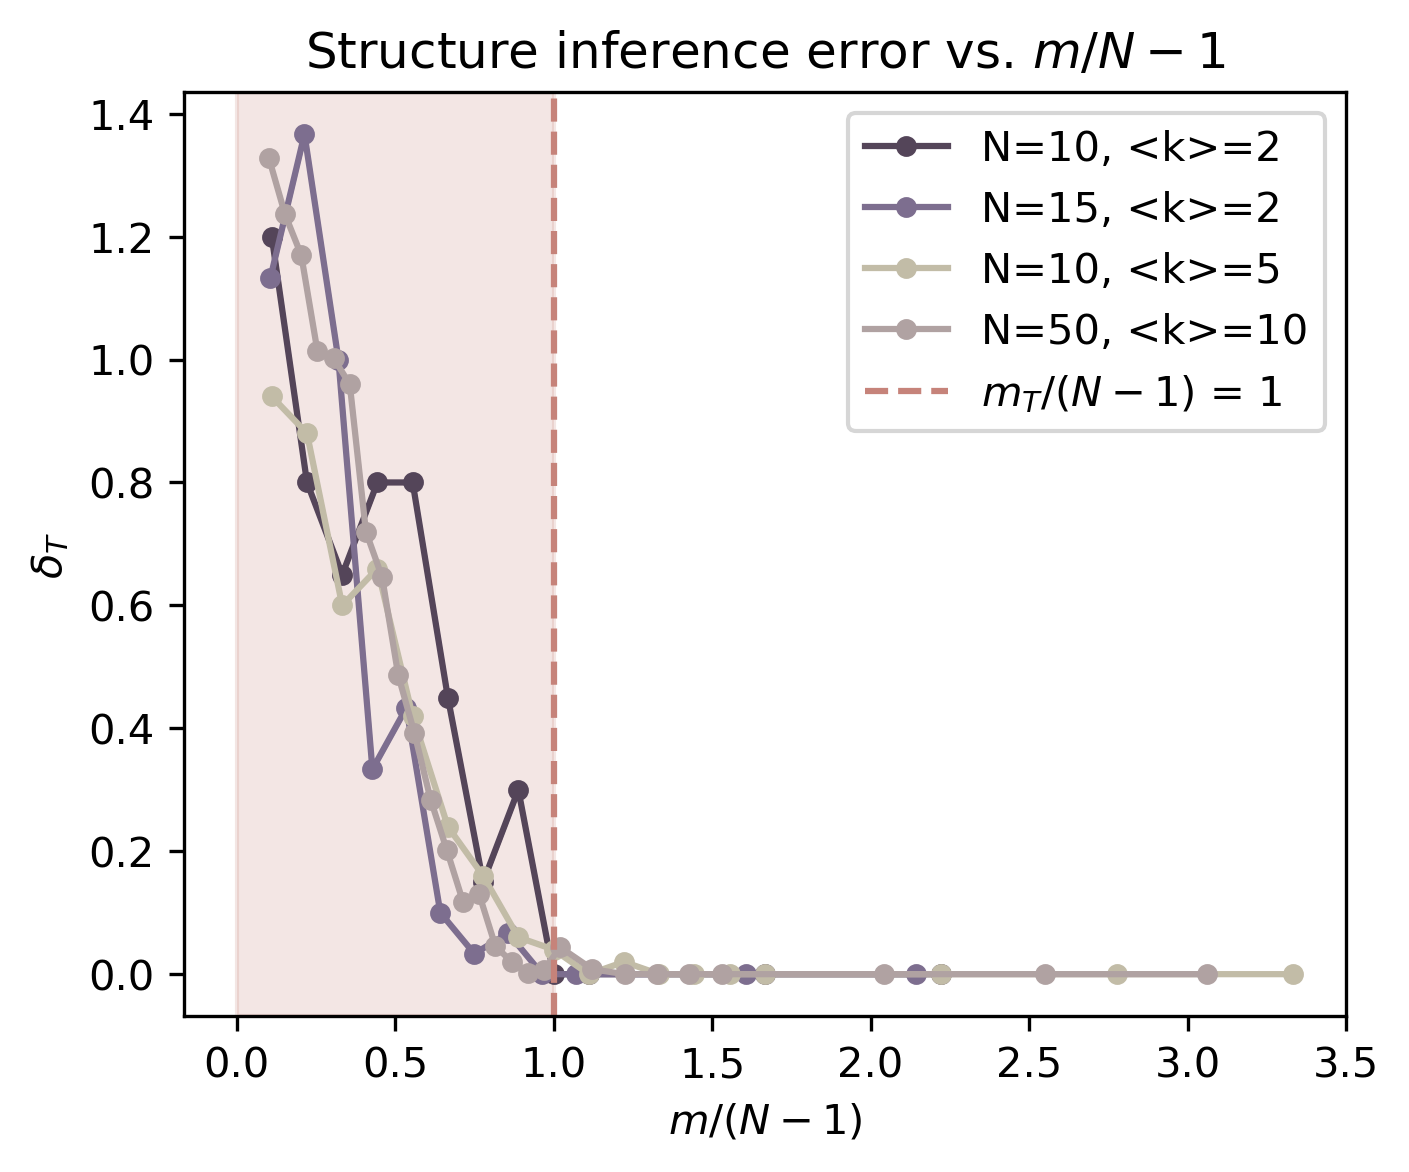

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
fig, (ax1) = plt.subplots(1,1, figsize = (5,4))
start = 0
end = -1

m1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2]
m = m1

ax1.plot([m[i]*10/9 for i in range(len(m))],results[f'errormean10'],marker='o',markersize = 4,color='#544559',label = 'N=10, <k>=2')
ax1.fill_between([m[i]*10/9 for i in range(len(m))], results[f'errormean10'][start:]-results[f'errorstd10'][start:], results[f'errormean10'][start:]+results[f'errorstd10'][start:], color='#544559', alpha=0.3)
ax1.plot([m[i]*15/14 for i in range(len(m))],results[f'errormean15'],marker='o',markersize = 4,color='#7d6e8f',label = 'N=15, <k>=2')
ax1.fill_between([m[i]*15/14 for i in range(len(m))], results[f'errormean15'][start:]-results[f'errorstd15'][start:], results[f'errormean15'][start:]+results[f'errorstd15'][start:], color='#7d6e8f', alpha=0.3)1.plot([m5[i]*10/9 for i in range(len(m5))],results[f'errormeand510'],marker='o',markersize = 4,color='#c2bca7',label = 'N=10, <k>=5')
ax1.fill_between([m5[i]*10/9 for i in range(len(m5))], results[f'errormeand510'][start:]-results[f'errorstdd510'][start:], results[f'errormeand510'][start:]+results[f'errorstdd510'][start:], color='#c2bca7',alpha=0.3)
ax1.plot([m10[i]*50/49 for i in range(len(m10))],results[f'errormeand1050'],marker='o',markersize = 4,color='#b0a2a2',label = 'N=50, <k>=10')
ax1.fill_between([m10[i]*50/49 for i in range(len(m10))], results[f'errormeand1050'][start:]-results[f'errorstdd1050'][start:], results[f'errormeand1050'][start:]+results[f'errorstdd1050'][start:], color='#b0a2a2',alpha=0.3)
ax1.axvspan(0, 1, alpha=0.2, color='#C6837A')
ax1.axvline(x=1, color='#C6837A', linestyle='--', label='$m/(N-1)$ = 1')
ax1.legend()
ax1.set_title('Structure inference error vs. $m/N-1$')
ax1.set_ylabel('$\delta_{T}$')
ax1.set_xlabel('$m/(N-1)$')
plt.savefig('kndyn/errorN_1_vs_mstruc2_new.pdf')
# plt.savefig('kndyn/errorN_1_vs_mstruc2_new.png')
